In [1]:
import numpy as np
import pennylane as qml
import random
import sys
import torch
import itertools
import scipy.stats
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from qiskit.quantum_info import random_clifford

C:\Users\Public\New folder\envs\QML\Lib\site-packages\pennylane\capture\capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.4.33 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [2]:
n_qubits = 4
dev1 = qml.device("default.qubit", wires=n_qubits)  #no edges
dev2 = qml.device("default.qubit", wires=n_qubits)
dev3 = qml.device("default.qubit", wires=n_qubits)
dev4 = qml.device("default.qubit", wires=n_qubits)
dev5 = qml.device("default.qubit", wires=n_qubits)
dev6 = qml.device("default.qubit", wires=n_qubits) 

base_edges2 = [(0, 1)]
base_edges3 = [(0, 1), (2, 3)]
base_edges4 = [(0, 1), (0, 2)]
base_edges5 = [(0, 1), (0,2), (2,3)]
base_edges6 = [(0, 1), (0,2), (0,3)]

# All 24 permutations of [0, 1, 2, 3]
permutations = list(itertools.permutations(range(n_qubits)))

@qml.qnode(dev1)
def run_permuted_graph_state1(permutation):
    for q in permutation:
        qml.Hadamard(wires=q)
    return qml.state()

@qml.qnode(dev2)
def run_permuted_graph_state2(permutation):
    for q in permutation:
        qml.Hadamard(wires=q)
    for (a, b) in base_edges2:
        qa = permutation[a]
        qb = permutation[b]
        qml.CZ(wires=[qa, qb])
    return qml.state()

@qml.qnode(dev3)
def run_permuted_graph_state3(permutation):
    for q in permutation:
        qml.Hadamard(wires=q)
    for (a, b) in base_edges3:
        qa = permutation[a]
        qb = permutation[b]
        qml.CZ(wires=[qa, qb])
    return qml.state()

@qml.qnode(dev4)
def run_permuted_graph_state4(permutation):
    for q in permutation:
        qml.Hadamard(wires=q)
    for (a, b) in base_edges4:
        qa = permutation[a]
        qb = permutation[b]
        qml.CZ(wires=[qa, qb])
    return qml.state()

@qml.qnode(dev5)
def run_permuted_graph_state5(permutation):
    for q in permutation:
        qml.Hadamard(wires=q)
    for (a, b) in base_edges5:
        qa = permutation[a]
        qb = permutation[b]
        qml.CZ(wires=[qa, qb])
    return qml.state()

@qml.qnode(dev6)
def run_permuted_graph_state6(permutation):
    for q in permutation:
        qml.Hadamard(wires=q)
    for (a, b) in base_edges6:
        qa = permutation[a]
        qb = permutation[b]
        qml.CZ(wires=[qa, qb])
    return qml.state()

states1 = []
for perm in permutations:
    state1 = run_permuted_graph_state1(perm)
    states1.append(state1)
states1 = np.array(states1, dtype=np.complex64)

states2 = []
for perm in permutations:
    state2 = run_permuted_graph_state2(perm)
    states2.append(state2)
states2 = np.array(states2, dtype=np.complex64)

states3 = []
for perm in permutations:
    state3 = run_permuted_graph_state3(perm)
    states3.append(state3)
states3 = np.array(states3, dtype=np.complex64)

states4 = []
for perm in permutations:
    state4 = run_permuted_graph_state4(perm)
    states4.append(state4)
states4 = np.array(states4, dtype=np.complex64)

states5 = []
for perm in permutations:
    state5 = run_permuted_graph_state5(perm)
    states5.append(state5)
states5 = np.array(states5, dtype=np.complex64)

states6 = []
for perm in permutations:
    state6 = run_permuted_graph_state6(perm)
    states6.append(state6)
states6 = np.array(states6, dtype=np.complex64)
print(len(states1), len(states2), len(states3), len(states4), len(states5), len(states6))

24 24 24 24 24 24


In [3]:
def QuantumStateDataset(states1, states2, states3, states4, states5, states6, num_samples=70):
    data = []
    labels = []

    for _ in range(num_samples):
        
        for i in range(24):
            matrix1, matrix2, matrix3, matrix4 = random_clifford_unitary(1), random_clifford_unitary(1), random_clifford_unitary(1), random_clifford_unitary(1)
            combined_matrix_in1 = np.kron(matrix1, matrix2)
            combined_matrix_in2 = np.kron(combined_matrix_in1, matrix3)
            combined_matrix = np.kron(combined_matrix_in2, matrix4)
            first_state = states1[i]    # Class no. 1
            second_state = states2[i]   # Class no. 2
            third_state = states3[i]    # Class no. 3
            fourth_state = states4[i]   # Class no. 4
            fifth_state = states5[i]    # Class no. 5
            sixth_state = states6[i]    # Class no. 6
       
            zero_label_states = [( first_state, 0)]
            one_label_states = [( fourth_state, 1), ( sixth_state , 1), (second_state , 1), (fifth_state  , 1), (third_state, 1)]

            if random.random() < 0.5:
                initial_state, label = random.choice(zero_label_states)
            else:
                initial_state, label = random.choice(one_label_states)
                
            resulting_state = np.dot(combined_matrix, initial_state)
            norm = np.linalg.norm(resulting_state)
            normalized_resulting_state = resulting_state / norm
            data.append(normalized_resulting_state)
            labels.append(label)
    return data, labels

def random_clifford_unitary(n, seed=None, su2=False):
    """Uniformly sample an n-qubit Clifford and return its unitary matrix."""
    C = random_clifford(n, seed=seed)   
    U_np = C.to_matrix()   
    U = torch.as_tensor(U_np, dtype=torch.complex64)
    return U

class QuantumStateTorchDataset(Dataset):
    def __init__(self, states, labels):
        # Convert complex input to real and imaginary parts
        self.states = torch.tensor(states, dtype=torch.complex64)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.states[idx], self.labels[idx]

class RealOutputWrapper(torch.nn.Module):
    def __init__(self, qlayer):
        super().__init__()
        self.qlayer = qlayer

    def forward(self, x):
        q_out = self.qlayer(x)
        return q_out.real 

def accuracy(X, Y):
    predictions = torch.sign(X)
    acc = ((predictions+Y)**2)/4
    return acc
    

In [4]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)
def variational_circuit(weights, inputs):
    qml.templates.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), normalize=True)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2)), qml.expval(qml.PauliZ(3))]

@qml.qnode(dev)
def quantum_model(weights, inputs):
    return variational_circuit(weights, inputs)

In [5]:
X_train_o, y_train_o = QuantumStateDataset(states1, states2, states3, states4, states5, states6, num_samples=200)
X_test_o, y_test_o = QuantumStateDataset(states1, states2, states3, states4, states5, states6, num_samples=200)

X_train= np.array(X_train_o)
y_train = np.array(y_train_o)
y_train = y_train.reshape(-1,1)
X_test= np.array(X_test_o)
y_test = np.array(y_test_o)
y_test = y_test.reshape(-1,1)

y_train = y_train * 2 - 1  
y_test = y_test * 2 - 1
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#print(X_train, X_test, y_train, y_test)

(4800, 16) (4800, 16) (4800, 1) (4800, 1)


In [6]:
num_layers = 4
lr=0.001
weight_shapes = {"weights": (num_layers, n_qubits, 3)}
num_epochs = 300
batch_size = 10
batches = (X_train.shape[0]) // batch_size
batches_test = (X_test.shape[0]) // batch_size

train_dataset = QuantumStateTorchDataset(X_train, y_train)
test_dataset = QuantumStateTorchDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
qlayer = qml.qnn.TorchLayer(quantum_model, weight_shapes)
clayer1 = torch.nn.Linear(4, 400)
clayer2 = torch.nn.Linear(400, 50)
clayer3 = torch.nn.Linear(50, 1)
tanh = torch.nn.Tanh()
model = torch.nn.Sequential(RealOutputWrapper(qlayer) , clayer1, tanh, clayer2, tanh, clayer3, tanh)
opt = torch.optim.Adam(model.parameters(), lr=lr)
loss = torch.nn.MSELoss()

In [8]:
epoch_list = []
loss_list = []
train_acc_list = []
test_acc_list = []
train_auc_list=[]
test_auc_list=[]

In [9]:
for epoch in range(num_epochs):

    running_loss = 0

    for x, y in train_loader:
        opt.zero_grad()
        #print(model(x).shape)
        #print(y.shape)
        # print(model(x).dtype)
        # print(y.dtype)
        loss_evaluated = loss(model(x), y)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    loss_list.append(avg_loss.item())
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

Average loss over epoch 1: 1.0244
Average loss over epoch 2: 1.0021
Average loss over epoch 3: 0.9466
Average loss over epoch 4: 0.4541
Average loss over epoch 5: 0.2662
Average loss over epoch 6: 0.2599
Average loss over epoch 7: 0.2549
Average loss over epoch 8: 0.2446
Average loss over epoch 9: 0.2347
Average loss over epoch 10: 0.2313
Average loss over epoch 11: 0.2243
Average loss over epoch 12: 0.2170
Average loss over epoch 13: 0.2121
Average loss over epoch 14: 0.2109
Average loss over epoch 15: 0.2073
Average loss over epoch 16: 0.2038
Average loss over epoch 17: 0.1970
Average loss over epoch 18: 0.1947
Average loss over epoch 19: 0.1889
Average loss over epoch 20: 0.1848
Average loss over epoch 21: 0.1839
Average loss over epoch 22: 0.1793
Average loss over epoch 23: 0.1699
Average loss over epoch 24: 0.1725
Average loss over epoch 25: 0.1717
Average loss over epoch 26: 0.1682
Average loss over epoch 27: 0.1680


KeyboardInterrupt: 

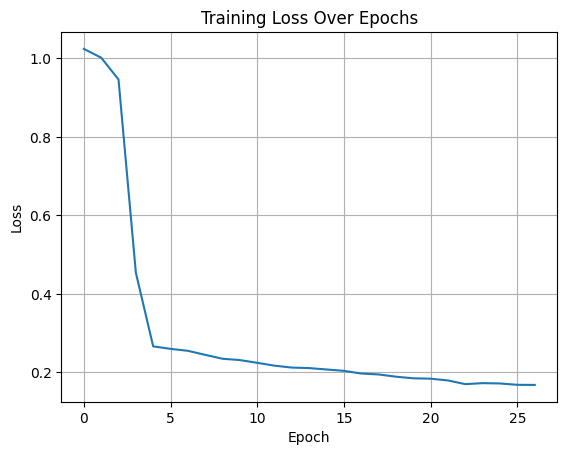

In [10]:
plt.plot(loss_list)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [11]:
running_loss=0
for x, y in train_loader:
        loss_evaluated = loss(model(x), y)
        running_loss += loss_evaluated
avg_loss = running_loss / batches
print("Average loss for training dataset",avg_loss)

running_acc=0
for x, y in train_loader:
        acc_evaluated = accuracy(model(x), y)
        running_acc += torch.mean(acc_evaluated) 
avg_acc = running_acc / batches
print("Accuracy for training dataset", avg_acc) 

Average loss for training dataset tensor(0.1613, grad_fn=<DivBackward0>)
Accuracy for training dataset tensor(0.9542, grad_fn=<DivBackward0>)


In [12]:
running_loss_test=0
for x, y in test_loader:
        loss_evaluated_test = loss(model(x), y)
        running_loss_test += loss_evaluated_test
avg_loss_test = running_loss_test / batches_test
print(batches_test)
print("Average loss for test dataset", avg_loss_test)

running_acc_test=0
for x, y in test_loader:
        acc_evaluated_test = accuracy(model(x), y)
        running_acc_test += torch.mean(acc_evaluated_test)
avg_acc_test = running_acc_test / batches_test
print("Accuracy for test dataset",avg_acc_test)

480
Average loss for test dataset tensor(0.1754, grad_fn=<DivBackward0>)
Accuracy for test dataset tensor(0.9494, grad_fn=<DivBackward0>)
